In [1]:
import os
import os.path as osp
import pandas as pd
import random
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from torchinfo import summary

In [2]:
data_dir = '/usr/users/agecker/datasets/pig_data_jonathan/weight_data'
# color_dir = osp.join(data_dir, 'color')
depth_dir = osp.join(data_dir, 'depth')
weights_train_df_path = osp.join(data_dir, 'weights_train.csv')
weights_val_df_path = osp.join(data_dir, 'weights_val.csv')

In [3]:
class WeightDataset(Dataset):
    def __init__(self, weights_df_path, images_base_dir, image_type):
        self.weights_df = pd.read_csv(weights_df_path)
        self.images_base_dir = images_base_dir
        self.image_type = image_type

    def __getitem__(self, i):
        # select row from dataframe and get corresponding group, weighting number, transponder number and weight
        info = self.weights_df.loc[i, ['group', 'weighting', 'transponder', 'weight']]
        transponder = info['transponder']
        weighting = info['weighting']
        group = info['group']
        weight = info['weight']
        weight = torch.tensor(weight).float()

        # load one random image corresponding to selected row
        images_folder = f'Gr_{group}_WG_{weighting}_{transponder}_{self.image_type}'
        images_dir = osp.join(self.images_base_dir, images_folder)
        image_name = random.choice(os.listdir(images_dir))
        image_path = osp.join(images_dir, image_name)
        image = Image.open(image_path)

        # transform and return image
        image = self.transform(image)
        return image, weight

    def __len__(self):
        return len(self.weights_df)

    def transform(self, image):
        transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])
        image = transform(image)
        return image


In [4]:
def back_to_original(image):
    image = image * torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    image = image + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    image = image * 255
    image = image.numpy()
    image = image.astype('uint8')
    image = np.transpose(image, [1, 2, 0])
    return image
    

In [5]:
trainset = WeightDataset(weights_train_df_path, depth_dir, 'depth')
valset = WeightDataset(weights_val_df_path, depth_dir, 'depth')
trainloader = DataLoader(trainset, batch_size=16)
valloader = DataLoader(valset, batch_size=16)

In [29]:
import torchvision.models as models


resnet34 = models.resnet34(pretrained=True)


/usr/users/henrich1/mambaforge/envs/exenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/users/henrich1/mambaforge/envs/exenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
from torchinfo import summary
summary(resnet34, (1, 3, 224, 224), row_settings=["var_names"])

Layer (type (var_name))                  Output Shape              Param #
ResNet (ResNet)                          [1, 1000]                 --
├─Conv2d (conv1)                         [1, 64, 112, 112]         9,408
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         128
├─ReLU (relu)                            [1, 64, 112, 112]         --
├─MaxPool2d (maxpool)                    [1, 64, 56, 56]           --
├─Sequential (layer1)                    [1, 64, 56, 56]           --
│    └─BasicBlock (0)                    [1, 64, 56, 56]           --
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d (bn1)            [1, 64, 56, 56]           128
│    │    └─ReLU (relu)                  [1, 64, 56, 56]           --
│    │    └─Conv2d (conv2)               [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d (bn2)            [1, 64, 56, 56]           128
│    │    └─ReLU (relu)                  [1, 64, 56, 56]           --
│

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.avg_pool(x).squeeze()
        x = self.fc(x)
        return x


def train(model, optimizer, trainloader):
    losses_epoch = []
    for input, target in trainloader:
        input, target = input.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(input).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return np.mean(losses_epoch)




# Initialize the model
model = SimpleCNN().cuda()

# Define a loss function and optimizer
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)




epochs = 100
losses = []
for epoch in tqdm(range(epochs)):
    loss = train(model, optimizer, trainloader)
    losses.append(loss)
    print(loss)
    
    

: 

# results

In [5]:
import matplotlib.pyplot as plt

In [6]:
results = pd.read_pickle('/usr/users/henrich1/exercises_summer_school/data/train_weight/metrics.pkl')

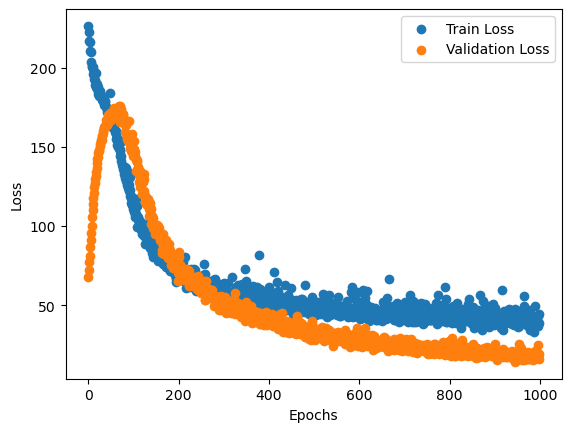

In [8]:
# Plot the losses
plt.scatter(range(len(results)), results['train_loss'], label='Train Loss')
plt.scatter(range(len(results)), results['val_loss'], label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()